In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from dataclasses import dataclass
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple

%matplotlib ipympl

In [2]:
with open('./solo/sequence.0/step0.frame_data.json') as json_file:
    data = json.load(json_file)
captures = data['captures']
def get_location(captures):
    # coeff = np.array([-0.00389254, 0.49512566, 0.13212298])

    def _find(l, s):
        for elem in l:
            if elem['id'] == s or elem['id'] == f'{s}_0':
                return elem['values'][0]
    
    def _get_bbox(view):
        '''
            For each view, extract the 2D bounding box and
        '''
        bbox_3d, bbox_2d = _find(view['annotations'], 'bounding box 3D'), _find(view['annotations'], 'bounding box')
        
        # refine 3D location of the object
        euler = R.from_quat(bbox_3d.get('rotation')).as_matrix()
        obj_location = view.get('position') + np.dot(bbox_3d['translation'], euler) - bbox_3d['size']*np.array([-0.00389254, 0.49512566, 0.13212298])

        # pre-process 2D bbox
        bbox = {
            'center': np.array(bbox_2d['origin']) + np.array(bbox_2d['dimension'])/2,
            'size': np.array(bbox_2d['dimension'])/2,
        }

        return obj_location, bbox

    angles = [
        [16, 240, 0],
        [17, 130, 0],
    ]
    bboxes, cameras = [], []
    for i, view in enumerate(captures):  # per view
        obj_location, bbox_2d = _get_bbox(view)

        bboxes.append(bbox_2d)
        cameras.append({
            'filename': view['filename'],
            'position': view['position'],
            # 'rotation': view['rotation'],
            'rotation': angles[i],
        })

    return {
        '3D_location': obj_location,
        'bboxes': bboxes,
        'cameras': cameras,
    }

output = get_location(captures)
print(output)

{'3D_location': array([-1.99999883,  0.20000001, -3.00000075]), 'bboxes': [{'center': array([1884.,  734.]), 'size': array([ 47., 176.])}, {'center': array([2299.,  827.]), 'size': array([106., 262.])}], 'cameras': [{'filename': 'step0.camera_0.png', 'position': [8.0, 2.5, 3.0], 'rotation': [16, 240, 0]}, {'filename': 'step0.camera.png', 'position': [-7.0, 2.5, 3.0], 'rotation': [17, 130, 0]}]}


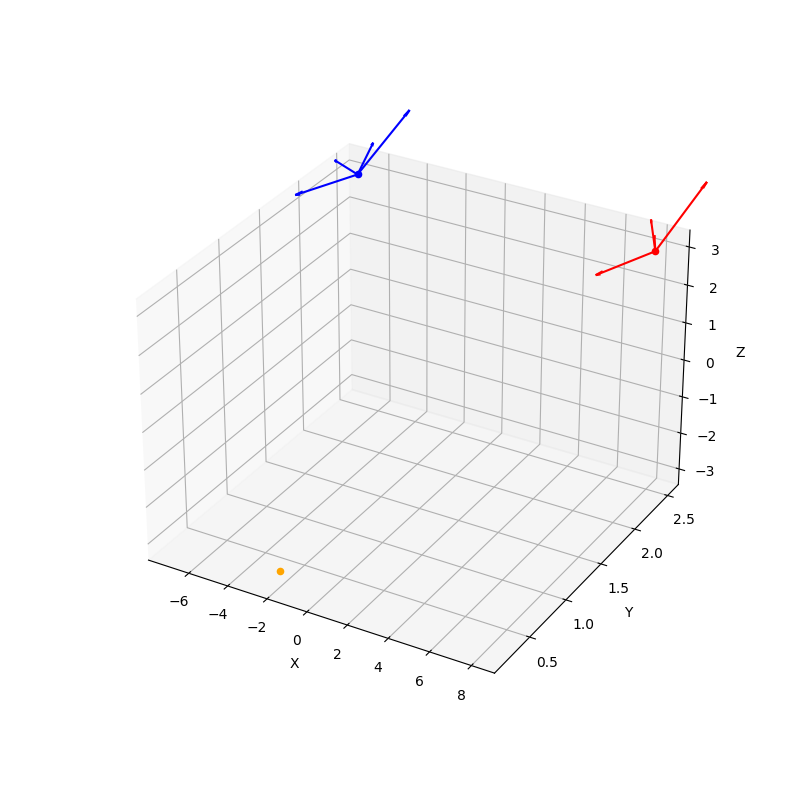

In [22]:
@dataclass
class Camera:
    position: np.ndarray#=field(default_factory=np.array([0., 0., 0.]))
    # angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in degrees
    angle: np.ndarray#=field(default_factory=np.array([0., 1., 0.]))  # angle in quaternion

    focal_length: float=20.
    resolution: np.ndarray=np.array([3840, 2160])
    sensor_size: np.ndarray=np.array([36, 36])
    fov: float=83.97443

    def __post_init__(self):
        beta, alpha, gamma = self.angle  # R_x, R_y, R_z | pitch, yaw, roll

        sin_beta, cos_beta = np.sin(np.deg2rad(beta)), np.cos(np.deg2rad(beta))
        sin_alpha, cos_alpha = np.sin(np.deg2rad(alpha)), np.cos(np.deg2rad(alpha))
        sin_gamma, cos_gamma = np.sin(np.deg2rad(gamma)), np.cos(np.deg2rad(gamma))
        self.rotation = np.array([
            [cos_alpha*cos_beta, cos_alpha*sin_beta*sin_gamma - sin_alpha*cos_gamma, cos_alpha*sin_beta*cos_gamma + sin_alpha*sin_gamma],
            [sin_alpha*cos_beta, sin_alpha*sin_beta*sin_gamma + cos_alpha*cos_gamma, sin_alpha*sin_beta*cos_gamma - cos_alpha*sin_gamma],
            [-sin_beta, cos_beta*sin_gamma, cos_beta*cos_gamma]
        ])

        # r = R.from_quat(self.angle)
        # self.rotation = r.as_matrix
        # print(r.as_euler('', degrees=True))
        # print('-'*30)

        self.intrinsic = np.array([
            [self.focal_length*self.resolution[0]/self.sensor_size[0], 0, self.resolution[0]/2],
            [0, self.focal_length*self.resolution[1]/self.sensor_size[1], self.resolution[1]/2],
            [0, 0, 1]
        ])

    def pixel2ray(self, pixel):
        pixel = np.append(pixel, np.zeros((pixel.shape[0], 1)) + 1, axis=-1)
        # pixel = pixel / self.focal_length
        translation = np.array(self.position) 
        camera_coor = pixel @ np.linalg.inv(self.intrinsic.T)
        # print(camera_coor, self.angle, self.position)
        # camera_coor = pixel @ np.linalg.inv(self.intrinsic).T
        world_coor = (camera_coor @ self.rotation) + translation
        # print(world_coor)

        vector = world_coor - self.position
        directional_vector = vector / np.linalg.norm(vector)
        
        return [Line(origin=coor, direction=vec) for coor, vec in zip(world_coor, directional_vector)]


@dataclass
class Line:
    origin: np.ndarray
    direction: np.ndarray

    @classmethod
    def from_bbox_and_camera(cls, pixel, camera):
        
        return cls()


def find_points(line_a: Line, line_b: Line):
    n = np.cross(line_a.direction, line_b.direction)
    d = np.abs(np.dot(n, line_a.origin - line_b.origin)) / np.linalg.norm(n)
    
    t_a = np.dot(np.cross(line_b.direction, n), (line_b.origin - line_a.origin)) / np.dot(n, n)
    t_b = np.dot(np.cross(line_a.direction, n), (line_b.origin - line_a.origin)) / np.dot(n, n)

    p_a = line_a.origin + t_a * line_a.direction
    p_b = line_b.origin + t_b * line_b.direction

    return (p_a + p_b) / 2

colors = ['red', 'blue']
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

cameras_ = [Camera(position=camera['position'], angle=camera['rotation']) for camera in output['cameras']]
for i, camera in enumerate(cameras_):
    ax.scatter(*camera.position, color=colors[i])

# lines = [camera.pixel2ray(bbox['center'][np.newaxis, :]) for bbox, camera in zip(output.get('bboxes'), cameras_)]
# lines = [camera.pixel2ray(camera.resolution[np.newaxis, :]/2) for bbox, camera in zip(output.get('bboxes'), cameras_)]
for i, (bbox, camera) in enumerate(zip(output.get('bboxes'), cameras_)):
    pixels = np.array([
        [0, 0],
        [0, 2160],
        [3840, 0],
        [3840, 2160],
        # [1920, 1080],
    ])
    rays = camera.pixel2ray(pixels)
    # t = np.linspace(-2, 1, 300)
    # ax.plot3D(
    #     line.origin[0] + t*line.direction[0],
    #     line.origin[1] + t*line.direction[1],
    #     line.origin[2] + t*line.direction[2],
    #     color=colors[i]
    # )
    stack_origin = np.stack([camera.position]*pixels.shape[0])
    ax.quiver(
        stack_origin[:, 0],
        stack_origin[:, 1],
        stack_origin[:, 2],
        np.array([r.direction for r in rays])[:, 0],
        np.array([r.direction for r in rays])[:, 1],
        np.array([r.direction for r in rays])[:, 2],
        color=colors[i], length=1.0, arrow_length_ratio=.1, normalize=True
    )

# point = find_points(*lines)
# print(point)
# print(output['3D_location'])
# ax.scatter(*point, color='purple')
ax.scatter(*output['3D_location'], color='orange')
plt.show()

In [ ]:
r = R.from_quat([-0.0695865452, 0.857597351, -0.120527431, -0.495134056])
print(r.as_euler('xyz', degrees=True))
print(r.as_euler('xzy', degrees=True))
print(r.as_euler('yzx', degrees=True))
print(r.as_euler('yxz', degrees=True))
print(r.as_euler('zxy', degrees=True))
print(r.as_euler('zyx', degrees=True))

In [24]:
r = R.from_rotvec([0, 0, 0], degrees=True)
print(r.as_matrix())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
